In [47]:
import geopandas as gpd

In [49]:
pip install geopandas pandas

In [50]:
# Charger les bâtiments
batiments = gpd.read_file("batiments.shp")

In [51]:
print(batiments.head())
print(batiments.columns)

    id_bat  nb_maisons                       geometry
0  E000270         1.0  POINT (531436.652 259655.507)
1  E000010         1.0  POINT (531445.663 259480.504)
2  E000060         1.0  POINT (531529.658 259588.506)
3  E000200         1.0  POINT (531217.642 259637.504)
4  E000249         1.0  POINT (531369.649 259611.505)
Index(['id_bat', 'nb_maisons', 'geometry'], dtype='object')


In [52]:
import pandas as pd

reseau = pd.read_excel("reseau_en_arbre.xlsx")

print(reseau.head())        # aperçu des premières lignes
print(reseau.columns)       # nom des colonnes
print(len(reseau))          # combien de lignes de connexion


  id_batiment  nb_maisons infra_id     infra_type   longueur
0     E000001           4  P007111  infra_intacte  12.314461
1     E000001           4  P007983  infra_intacte  40.320929
2     E000001           4  P000308  infra_intacte  39.140799
3     E000001           4  P007819  infra_intacte  17.390464
4     E000002           1  P007111  infra_intacte  12.314461
Index(['id_batiment', 'nb_maisons', 'infra_id', 'infra_type', 'longueur'], dtype='object')
6107


In [53]:
pip install networkx


Note: you may need to restart the kernel to use updated packages.


In [54]:
import networkx as nx

# Créer un graphe orienté ou non orienté (ici non orienté)
G = nx.Graph()

# Ajouter les arêtes avec les coûts
for _, row in reseau.iterrows():
    G.add_edge(row['id_batiment'], row['infra_id'], weight=row['longueur'])

# Vérifier le nombre de nœuds et d'arêtes
print("Nombre de nœuds :", G.number_of_nodes())
print("Nombre d'arêtes :", G.number_of_edges())

# Exemple : afficher quelques arêtes avec leurs poids
edges_sample = list(G.edges(data=True))[:5]
print("\nExemple de connexions :", edges_sample)


Nombre de nœuds : 1025
Nombre d'arêtes : 5586

Exemple de connexions : [('E000001', 'P007111', {'weight': 12.3144613356693}), ('E000001', 'P007983', {'weight': 40.3209288665353}), ('E000001', 'P000308', {'weight': 39.1407985664577}), ('E000001', 'P007819', {'weight': 17.3904643240185}), ('P007111', 'E000002', {'weight': 12.3144613356693})]


In [55]:
# difficulté de CHAQUE LIGNE d'infrastructure
reseau['difficulte_infra'] = reseau['longueur'] / reseau['nb_maisons']

print("Aperçu avec la difficulté de l'infra :")
print(reseau[['id_batiment', 'infra_id', 'nb_maisons', 'longueur', 'difficulte_infra']].head())


Aperçu avec la difficulté de l'infra :
  id_batiment infra_id  nb_maisons   longueur  difficulte_infra
0     E000001  P007111           4  12.314461          3.078615
1     E000001  P007983           4  40.320929         10.080232
2     E000001  P000308           4  39.140799          9.785200
3     E000001  P007819           4  17.390464          4.347616
4     E000002  P007111           1  12.314461         12.314461


In [56]:
# On regroupe par bâtiment et on additionne les difficultés des lignes
difficulte_batiment = (
    reseau.groupby('id_batiment')['difficulte_infra']
    .sum()
    .reset_index()
)

# On renomme la colonne pour que ce soit clair
difficulte_batiment = difficulte_batiment.rename(columns={
    'difficulte_infra': 'difficulte_batiment'
})

print("Difficulté totale par bâtiment :")
print(difficulte_batiment.head())


Difficulté totale par bâtiment :
  id_batiment  difficulte_batiment
0     E000001            27.291663
1     E000002           102.690815
2     E000003            79.170312
3     E000004           129.893519
4     E000005           133.901777


In [57]:
# Combien de bâtiments sont reliés par chaque infrastructure ?
mutualisation = (
    reseau.groupby('infra_id')['id_batiment']
    .count()
    .reset_index()
    .rename(columns={'id_batiment': 'nb_batiments_connectes'})
)

print("Mutualisation des infrastructures :")
print(mutualisation.head())


Mutualisation des infrastructures :
  infra_id  nb_batiments_connectes
0  P000003                       2
1  P000009                       6
2  P000015                       4
3  P000020                      28
4  P000023                      16


In [58]:
# On ajoute l'info mutualisation dans le dataframe reseau
reseau_mutualise = reseau.merge(mutualisation, on='infra_id', how='left')

# Par sécurité, si une infra ne connecte qu'un seul bâtiment, on met 1
reseau_mutualise['nb_batiments_connectes'] = reseau_mutualise['nb_batiments_connectes'].fillna(1)

# Difficulté corrigée par ligne d'infra
reseau_mutualise['difficulte_corrigee_infra'] = (
    reseau_mutualise['longueur'] / (
        reseau_mutualise['nb_maisons'] * reseau_mutualise['nb_batiments_connectes']
    )
)

print("Aperçu avec difficulté corrigée par infra :")
print(
    reseau_mutualise[[
        'id_batiment', 'infra_id', 'longueur', 'nb_maisons', 
        'nb_batiments_connectes', 'difficulte_corrigee_infra'
    ]].head()
)


Aperçu avec difficulté corrigée par infra :
  id_batiment infra_id   longueur  nb_maisons  nb_batiments_connectes  \
0     E000001  P007111  12.314461           4                     414   
1     E000001  P007983  40.320929           4                      43   
2     E000001  P000308  39.140799           4                      36   
3     E000001  P007819  17.390464           4                       1   
4     E000002  P007111  12.314461           1                     414   

   difficulte_corrigee_infra  
0                   0.007436  
1                   0.234424  
2                   0.271811  
3                   4.347616  
4                   0.029745  


In [59]:
plan_final_difficulte = (
    reseau_mutualise
    .groupby('id_batiment')['difficulte_corrigee_infra']
    .sum()
    .reset_index()
    .rename(columns={'difficulte_corrigee_infra': 'difficulte_finale'})
)

# On trie du plus facile (petite difficulté_finale) au plus difficile
plan_final_difficulte = plan_final_difficulte.sort_values(by='difficulte_finale', ascending=True)

print("Bâtiments à raccorder en premier (les plus faciles) :")
print(plan_final_difficulte.head(20))


Bâtiments à raccorder en premier (les plus faciles) :
    id_batiment  difficulte_finale
0       E000001           4.861287
7       E000008           6.565868
6       E000007           6.644676
123     E000124           7.678924
138     E000139           8.274536
275     E000276           8.301656
8       E000009           8.345817
44      E000045           8.375944
205     E000206           8.415878
198     E000199           8.572427
163     E000164           8.667302
139     E000140           8.784148
185     E000186           9.512221
33      E000034           9.740416
153     E000154           9.782863
24      E000025           9.850159
141     E000142           9.900631
206     E000207           9.927190
124     E000125          10.109111
164     E000165          10.437514


In [60]:
# On s'assure que les deux colonnes sont bien du même type (texte)
batiments['id_bat'] = batiments['id_bat'].astype(str)
plan_final_difficulte['id_batiment'] = plan_final_difficulte['id_batiment'].astype(str)

# Fusionner pour ajouter la difficulté dans la géométrie
batiments_difficulte = batiments.merge(
    plan_final_difficulte,
    left_on='id_bat',
    right_on='id_batiment',
    how='left'
)

# Vérif rapide
print(batiments_difficulte.head())


    id_bat  nb_maisons                       geometry id_batiment  \
0  E000270         1.0  POINT (531436.652 259655.507)     E000270   
1  E000010         1.0  POINT (531445.663 259480.504)     E000010   
2  E000060         1.0  POINT (531529.658 259588.506)     E000060   
3  E000200         1.0  POINT (531217.642 259637.504)     E000200   
4  E000249         1.0  POINT (531369.649 259611.505)     E000249   

   difficulte_finale  
0          15.759231  
1          11.664687  
2          30.229074  
3          16.685729  
4          15.633049  


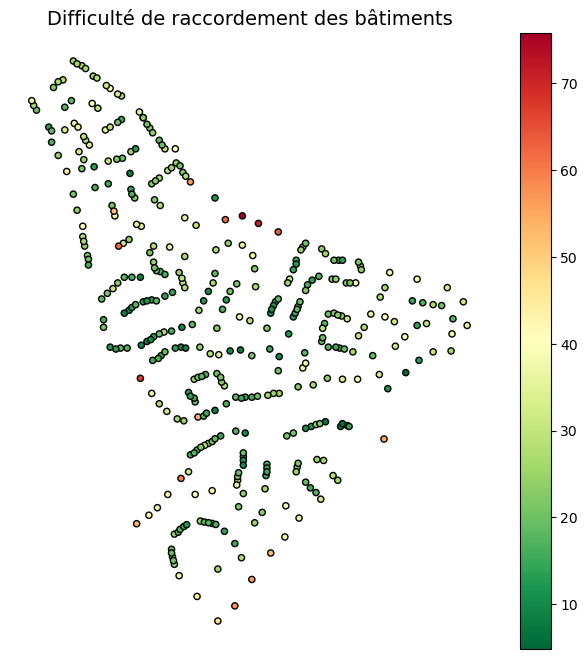

In [61]:
# Créer la carte avec couleurs selon la difficulté
ax = batiments_difficulte.plot(
    column='difficulte_finale',
    cmap='RdYlGn_r',  # rouge = difficile, vert = facile
    legend=True,
    figsize=(8,8),
    markersize=20,
    edgecolor='black'
)

ax.set_title("Difficulté de raccordement des bâtiments", fontsize=14)
ax.set_axis_off()


In [62]:
import pandas as pd
import numpy as np


In [63]:
# 1. Réseau en arbre : liens entre bâtiments et infrastructures
reseau = pd.read_excel("reseau_en_arbre.xlsx")

# 2. Détails supplémentaires sur les infrastructures
infra_details = pd.read_csv("infra.csv")

# 3. Infos supplémentaires sur les bâtiments (ex : urgence)
batiments_info = pd.read_csv("batiments_des.csv")

print("reseau_en_arbre :")
print(reseau.head(), "\n")

print("infra_details :")
print(infra_details.head(), "\n")

print("batiments_info :")
print(batiments_info.head())


reseau_en_arbre :
  id_batiment  nb_maisons infra_id     infra_type   longueur
0     E000001           4  P007111  infra_intacte  12.314461
1     E000001           4  P007983  infra_intacte  40.320929
2     E000001           4  P000308  infra_intacte  39.140799
3     E000001           4  P007819  infra_intacte  17.390464
4     E000002           1  P007111  infra_intacte  12.314461 

infra_details :
  id_infra type_infra
0  P000719     aerien
1  P007118     aerien
2  P007170   fourreau
3  P007648     aerien
4  P000306     aerien 

batiments_info :
  id_batiment type_batiment  nb_maisons
0     E000160    habitation           8
1     E000367    habitation           3
2     E000032    habitation           1
3     E000017    habitation           7
4     E000339    habitation           1


In [64]:
# Table de correspondance coût et temps par type d'infrastructure
couts_infra = pd.DataFrame({
    'type_infra': ['aerien', 'semi-aerien', 'fourreau'],
    'prix_par_m': [500, 750, 500],      # en euros par mètre
    'heures_par_m': [2, 4, 5]           # en heures par mètre
})

print("Table coûts_infra :")
print(couts_infra)


Table coûts_infra :
    type_infra  prix_par_m  heures_par_m
0       aerien         500             2
1  semi-aerien         750             4
2     fourreau         500             5


In [70]:
# On suppose que infra_details a les colonnes ['infra_id', 'type_infra']
# Si les colonnes sont nommées différemment, ajuste ici

# Joindre reseau et infra_details pour connaître le type de chaque infra
reseau2 = reseau.merge(infra_details, left_on='infra_id', right_on='id_infra', how='left')


# Joindre avec la table de coûts pour avoir prix_par_m et heures_par_m
reseau2 = reseau2.merge(couts_infra, on='type_infra', how='left')

# Calculer coût total et durée totale pour chaque tronçon d'infrastructure
reseau2['cout_total'] = reseau2['prix_par_m'] * reseau2['longueur']
reseau2['duree_totale_h'] = reseau2['heures_par_m'] * reseau2['longueur']

print("reseau2 enrichi :")
print(reseau2.head())


reseau2 enrichi :
  id_batiment  nb_maisons infra_id     infra_type   longueur id_infra  \
0     E000001           4  P007111  infra_intacte  12.314461  P007111   
1     E000001           4  P007983  infra_intacte  40.320929  P007983   
2     E000001           4  P000308  infra_intacte  39.140799  P000308   
3     E000001           4  P007819  infra_intacte  17.390464  P007819   
4     E000002           1  P007111  infra_intacte  12.314461  P007111   

  type_infra  prix_par_m  heures_par_m    cout_total  duree_totale_h  
0   fourreau         500             5   6157.230668       61.572307  
1     aerien         500             2  20160.464433       80.641858  
2   fourreau         500             5  19570.399283      195.703993  
3   fourreau         500             5   8695.232162       86.952322  
4   fourreau         500             5   6157.230668       61.572307  


In [72]:
reseau2['difficulte_troncon'] = (
    (reseau2['cout_total'] * reseau2['duree_totale_h']) / reseau2['nb_maisons']
)

print("Avec difficulté_troncon :")
print(reseau2[['id_batiment','infra_id','nb_maisons','cout_total','duree_totale_h','difficulte_troncon']].head())


Avec difficulté_troncon :
  id_batiment infra_id  nb_maisons    cout_total  duree_totale_h  \
0     E000001  P007111           4   6157.230668       61.572307   
1     E000001  P007983           4  20160.464433       80.641858   
2     E000001  P000308           4  19570.399283      195.703993   
3     E000001  P007819           4   8695.232162       86.952322   
4     E000002  P007111           1   6157.230668       61.572307   

   difficulte_troncon  
0        94778.723742  
1       406444.326165  
2       957501.320263  
3       189017.655878  
4       379114.894969  


In [74]:
# Nombre de bâtiments par infrastructure
mutualisation = (
    reseau2.groupby('infra_id')['id_batiment']
    .count()
    .reset_index()
    .rename(columns={'id_batiment':'nb_batiments_connectes'})
)

# Fusionner cette info dans reseau2
reseau3 = reseau2.merge(mutualisation, on='infra_id', how='left')

# Sécurité : si NaN -> remplacer par 1
reseau3['nb_batiments_connectes'] = reseau3['nb_batiments_connectes'].fillna(1)

# Difficulté corrigée avec mutualisation
reseau3['difficulte_corrigee_troncon'] = reseau3['difficulte_troncon'] / reseau3['nb_batiments_connectes']

print("reseau3 avec mutualisation :")
print(reseau3[['id_batiment','infra_id','difficulte_troncon','nb_batiments_connectes','difficulte_corrigee_troncon']].head())


reseau3 avec mutualisation :
  id_batiment infra_id  difficulte_troncon  nb_batiments_connectes  \
0     E000001  P007111        94778.723742                     414   
1     E000001  P007983       406444.326165                      43   
2     E000001  P000308       957501.320263                      36   
3     E000001  P007819       189017.655878                       1   
4     E000002  P007111       379114.894969                     414   

   difficulte_corrigee_troncon  
0                   228.934115  
1                  9452.193632  
2                 26597.258896  
3                189017.655878  
4                   915.736461  


In [80]:
# Ajouter une colonne "poids_urgence" selon le type de bâtiment
urgence_map = {
    'hopital': 3,
    'ecole': 2,
    'mairie': 2,
    'commerce': 2,
    'habitation': 1
}

batiments_info['poids_urgence'] = batiments_info['type_batiment'].map(urgence_map)

# Si le type ne figure pas dans la table (NaN), on met 1 par défaut
batiments_info['poids_urgence'] = batiments_info['poids_urgence'].fillna(1)

print("✅ Colonnes enrichies avec poids d'urgence :")
print(batiments_info.head())


✅ Colonnes enrichies avec poids d'urgence :
  id_batiment type_batiment  nb_maisons  poids_urgence
0     E000160    habitation           8            1.0
1     E000367    habitation           3            1.0
2     E000032    habitation           1            1.0
3     E000017    habitation           7            1.0
4     E000339    habitation           1            1.0
